In [3]:
from fastai.vision.all import *
path = Path('amazon-data')

In [4]:
# Check the contents of the path
path.ls()

(#4) [Path('amazon-data/sample_submission_v2.csv'),Path('amazon-data/test-jpg'),Path('amazon-data/train-jpg'),Path('amazon-data/train_v2.csv')]

In [5]:
train_df = pd.read_csv(path/'train_v2.csv')
train_df

image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]

In [6]:
train_df.drop(train_df[train_df["tags"] == "cloudy"].index, inplace=True)
train_df.drop(train_df[train_df["tags"].str.contains("habitation")].index, inplace=True)
train_df.drop(train_df[train_df["tags"].str.contains("haze")].index, inplace=True)

In [7]:
import pandas as pd

# lista de labels care sunt deforestare
keywords = ["agriculture","artisinal_mine","conventional_mine","road","cultivation","selective_logging","slash_burn"]

def check_tags(tags):
    for keyword in keywords:
        if keyword in tags:
            return "deforestation"
    return "not_deforestation"

# aplicam functia pe coloana tags pentru a crea coloana label
train_df["label"] = train_df["tags"].apply(check_tags)
train_df

image_name                                           tags  \
1          train_1                agriculture clear primary water   
2          train_2                                  clear primary   
3          train_3                                  clear primary   
6          train_6    agriculture clear cultivation primary water   
8          train_8          agriculture clear cultivation primary   
...            ...                                            ...   
40472  train_40472                      agriculture clear primary   
40474  train_40474                                  clear primary   
40476  train_40476                      agriculture clear primary   
40477  train_40477                 agriculture clear primary road   
40478  train_40478  agriculture cultivation partly_cloudy primary   

                   label  
1          deforestation  
2      not_deforestation  
3      not_deforestation  
6          deforestation  
8          deforestation  
...                  ...  
40472      deforestation  
40474  not_deforestation  
40476      deforestation  
40477      deforestation  
40478      deforestation  

[32162 rows x 3 columns]

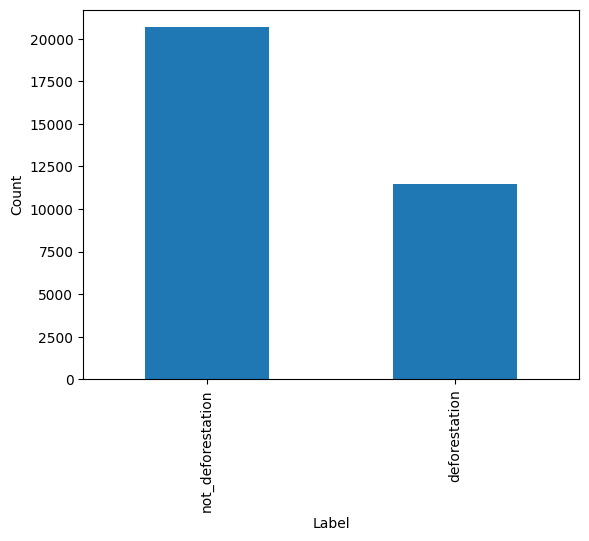

In [8]:
import matplotlib.pyplot as plt

counts = train_df["label"].value_counts()
counts.plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [9]:
counts

label
not_deforestation    20675
deforestation        11487
Name: count, dtype: int64

In [10]:
labels = train_df['label']

In [11]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(2),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


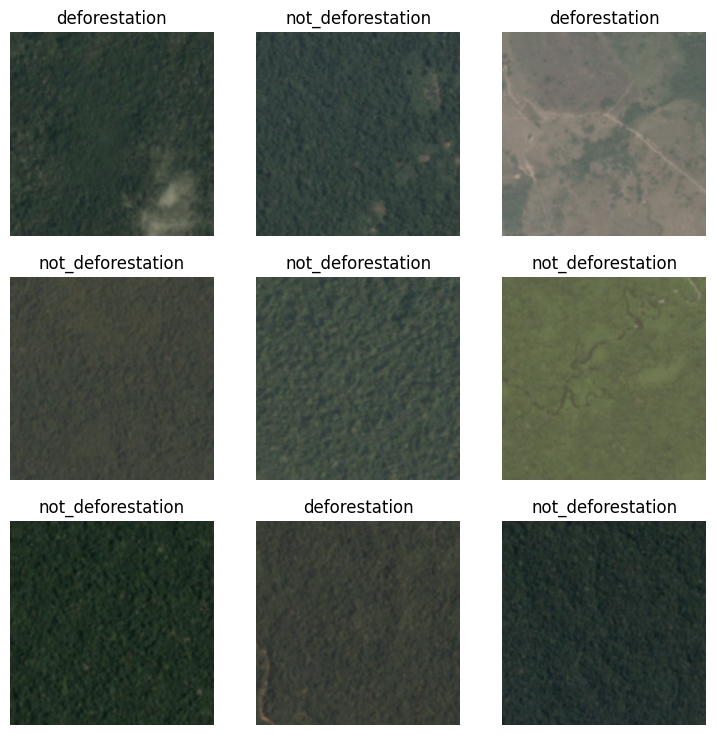

In [12]:
dls = get_data(224,64)
dls.show_batch()

In [13]:
f1score = F1Score(average='binary')
recall = Precision()

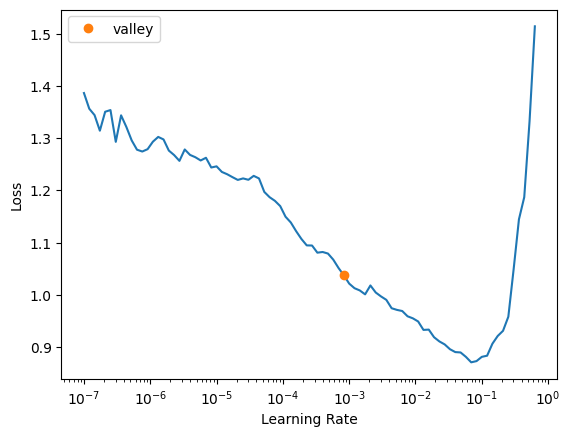

In [20]:
learn = vision_learner(dls, resnet50, metrics=[f1score, recall]).to_fp16()
lr_min = learn.lr_find()

In [23]:
lr_min

SuggestedLRs(valley=0.0008317637839354575)

In [24]:
learn.fine_tune(4, base_lr=0.0008317637839354575,freeze_epochs=4)

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppD

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppD

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not 

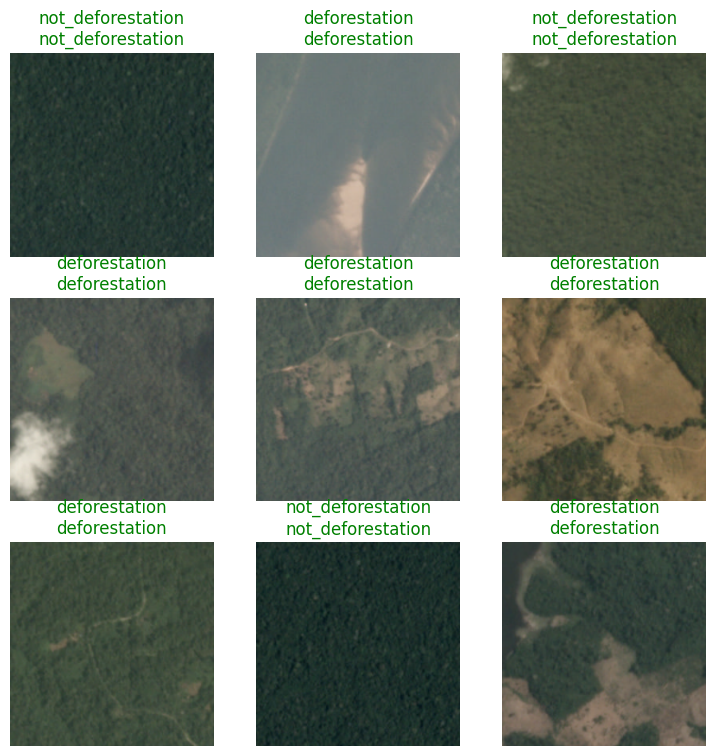

In [25]:
learn.show_results()

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


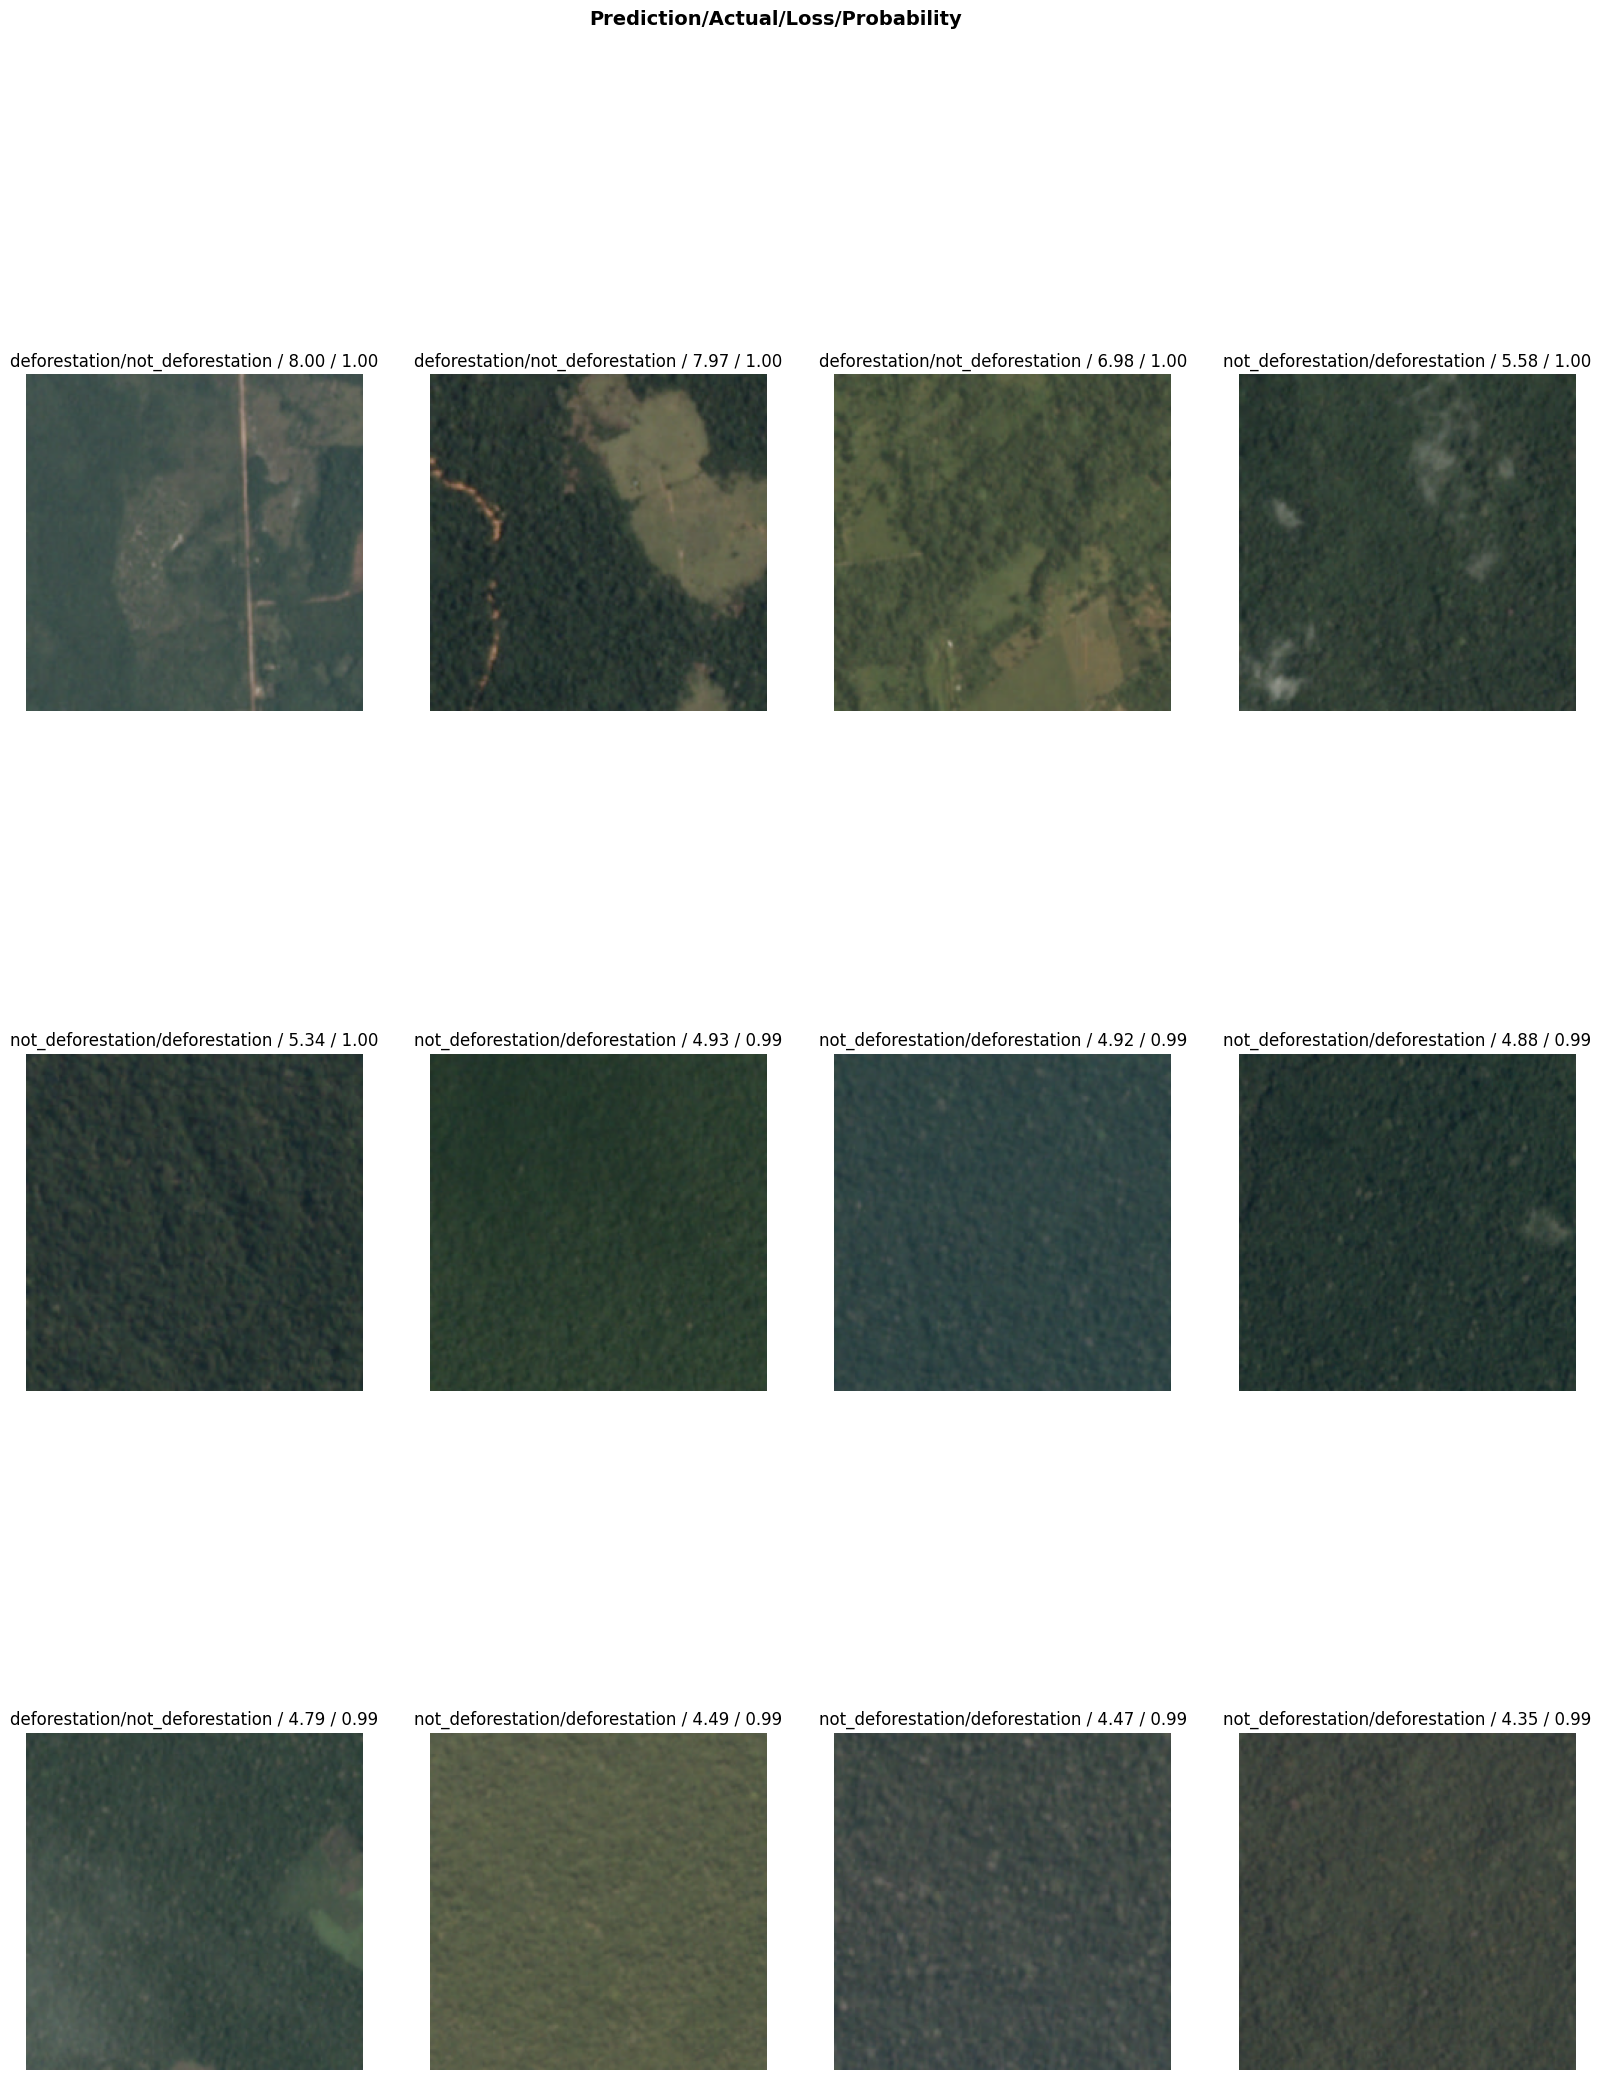

In [27]:
interp.plot_top_losses(12, figsize=(20,25))

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


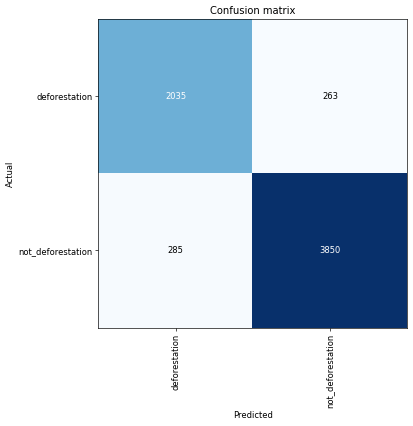

In [28]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [ ]:
learn.export('resnet50.pkl')

In [1]:
from fastai.vision.all import *

In [2]:
inference = load_learner('resnet50.pkl', cpu=True)

In [18]:
from pathlib import Path
import pandas as pd

# Define the base paths for the two directories
base_path = Path('sentinel-data/labels')
deforestation_path = base_path / 'deforestation'
not_deforestation_path = base_path / 'not_deforestation'

# Function to create a DataFrame from directory
def create_df_from_dir(directory_path, label):
    images = list(directory_path.glob('*.jpg'))  # Assuming images are in JPG format
    return pd.DataFrame({'image': images, 'label': [label] * len(images)})

# Create DataFrames for both directories
df_deforestation = create_df_from_dir(deforestation_path, 'deforestation')
df_not_deforestation = create_df_from_dir(not_deforestation_path, 'not_deforestation')

# Concatenate both DataFrames
submission_df = pd.concat([df_deforestation, df_not_deforestation], ignore_index=True)

# Save to CSV
submission_df.to_csv('sentinel-data/test-jpg.csv', index=False)

In [19]:
testing_path = submission_df['image']


In [21]:
tst_dl = inference.dls.test_dl(testing_path)

predictions = inference.get_preds(dl=tst_dl)

In [22]:
predictions

(tensor([[0.5587, 0.4413],
         [0.5290, 0.4710],
         [0.3406, 0.6594],
         ...,
         [0.2349, 0.7651],
         [0.4975, 0.5025],
         [0.3663, 0.6337]]),
 None)

In [23]:
pred_probs = predictions[0]

pred_labels = [inference.dls.vocab[i] for i in pred_probs.argmax(dim=1)]

preds = submission_df
preds['predicted label'] = pred_labels

In [24]:
pred_probs_max, _ = torch.max(pred_probs, dim=1)
pred_probs_min, _ = torch.min(pred_probs, dim=1)
preds['probability of correct class'] = pred_probs_max.numpy()
preds['probability of incorrect class'] = pred_probs_min.numpy()
preds['diff'] = preds['probability of correct class'] - preds['probability of incorrect class']

In [25]:
incorrect_df = preds[preds["label"] != preds["predicted label"]]

In [26]:
incorrect_df

image  \
2         sentinel-data\labels\deforestation\fragment_S2A_MSIL2A_20220722T092041_N0400_R093_T35TLL_20220722T134859_0_36.jpg   
21       sentinel-data\labels\deforestation\fragment_S2A_MSIL2A_20220722T092041_N0400_R093_T35TLL_20220722T134859_10_44.jpg   
22       sentinel-data\labels\deforestation\fragment_S2A_MSIL2A_20220722T092041_N0400_R093_T35TLL_20220722T134859_10_46.jpg   
28       sentinel-data\labels\deforestation\fragment_S2A_MSIL2A_20220722T092041_N0400_R093_T35TLL_20220722T134859_11_51.jpg   
29       sentinel-data\labels\deforestation\fragment_S2A_MSIL2A_20220722T092041_N0400_R093_T35TLL_20220722T134859_11_52.jpg   
...                                                                                                                     ...   
1576  sentinel-data\labels\not_deforestation\fragment_S2A_MSIL2A_20220725T093041_N0400_R136_T34TFS_20220725T140223_6_42.jpg   
1578  sentinel-data\labels\not_deforestation\fragment_S2A_MSIL2A_20220725T093041_N0400_R136_T34TFS_20220725T140223_6_51.jpg   
1579  sentinel-data\labels\not_deforestation\fragment_S2A_MSIL2A_20220725T093041_N0400_R136_T34TFS_20220725T140223_7_39.jpg   
1580  sentinel-data\labels\not_deforestation\fragment_S2A_MSIL2A_20220725T093041_N0400_R136_T34TFS_20220725T140223_7_51.jpg   
1581  sentinel-data\labels\not_deforestation\fragment_S2A_MSIL2A_20220725T093041_N0400_R136_T34TFS_20220725T140223_8_39.jpg   

                  label    predicted label  probability of correct class  \
2         deforestation  not_deforestation                      0.659353   
21        deforestation  not_deforestation                      0.715739   
22        deforestation  not_deforestation                      0.565286   
28        deforestation  not_deforestation                      0.643680   
29        deforestation  not_deforestation                      0.657612   
...                 ...                ...                           ...   
1576  not_deforestation      deforestation                      0.637250   
1578  not_deforestation      deforestation                      0.629182   
1579  not_deforestation      deforestation                      0.567415   
1580  not_deforestation      deforestation                      0.516179   
1581  not_deforestation      deforestation                      0.560765   

      probability of incorrect class      diff  
2                           0.340647  0.318707  
21                          0.284261  0.431478  
22                          0.434714  0.130571  
28                          0.356320  0.287360  
29                          0.342388  0.315224  
...                              ...       ...  
1576                        0.362750  0.274500  
1578                        0.370818  0.258364  
1579                        0.432585  0.134829  
1580                        0.483821  0.032358  
1581                        0.439235  0.121530  

[341 rows x 6 columns]

In [27]:
incorrect_df.reset_index(drop=True, inplace=True)

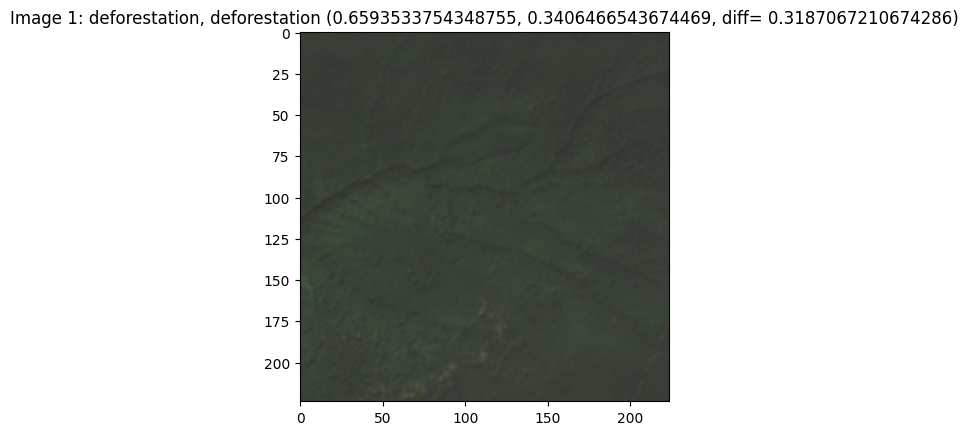

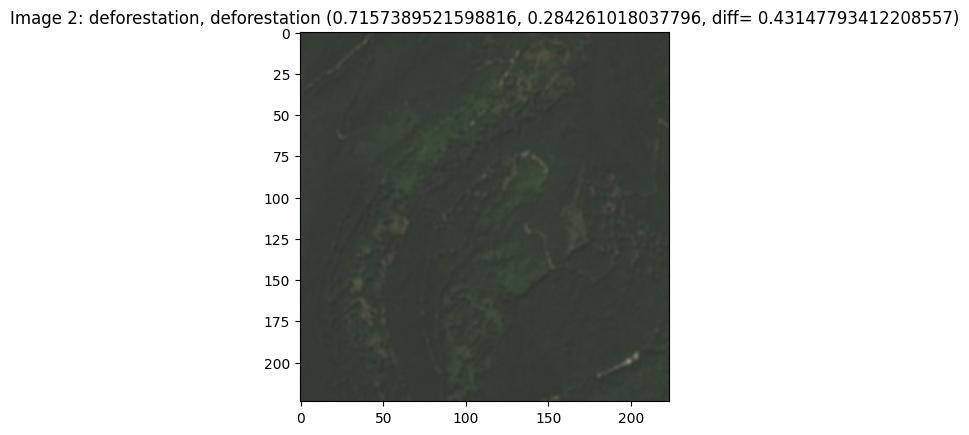

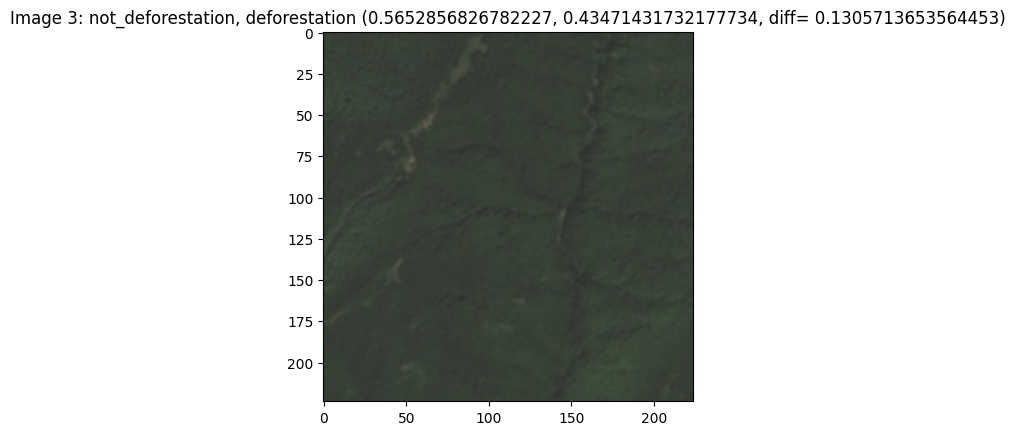

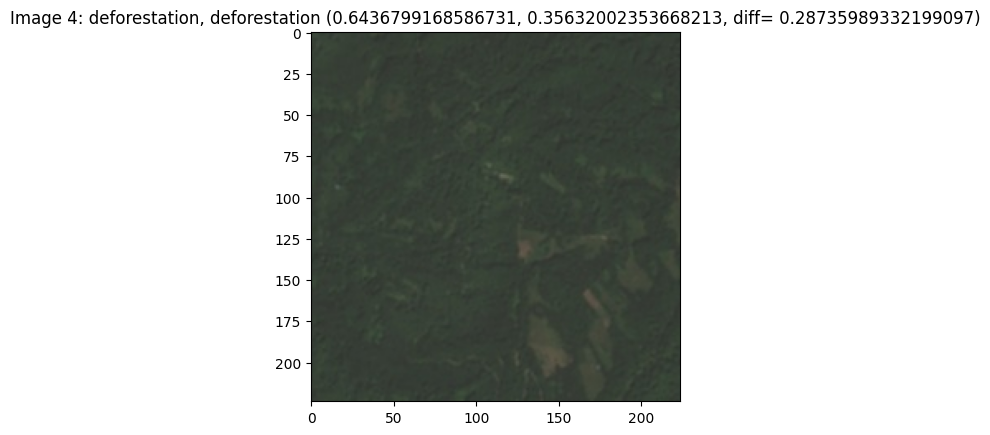

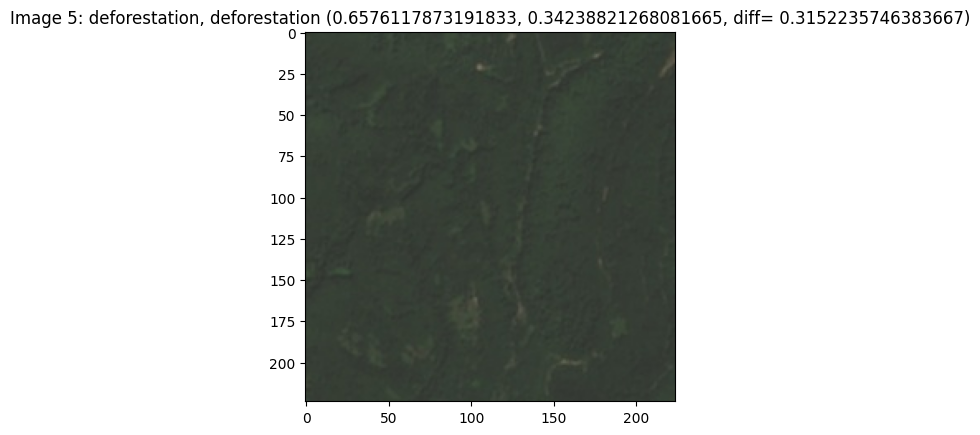

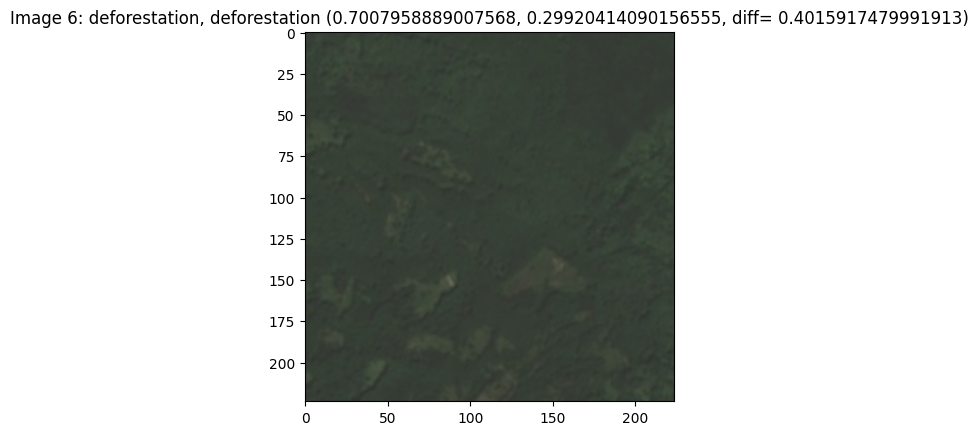

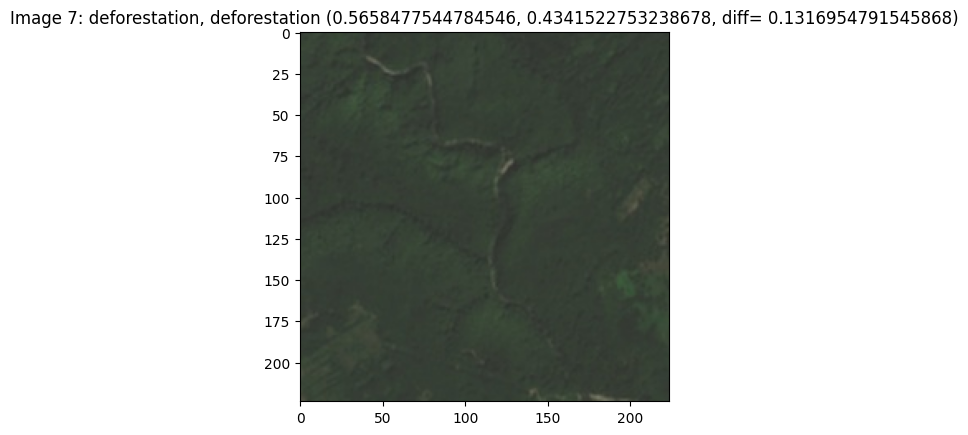

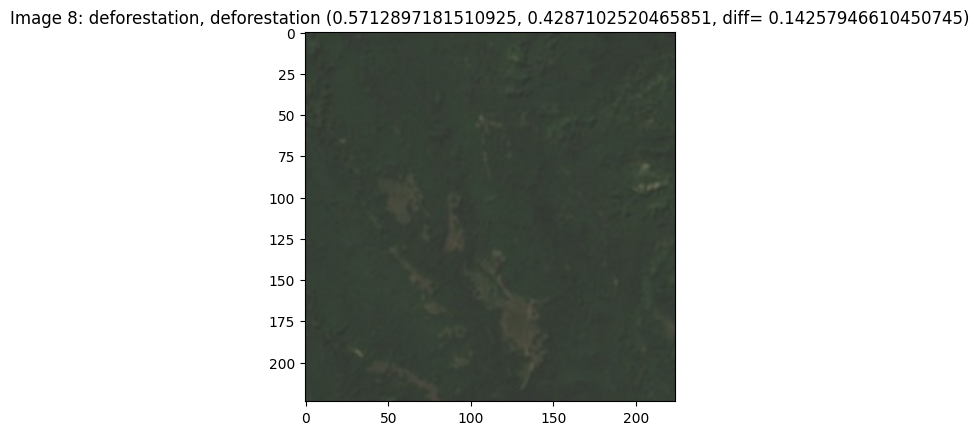

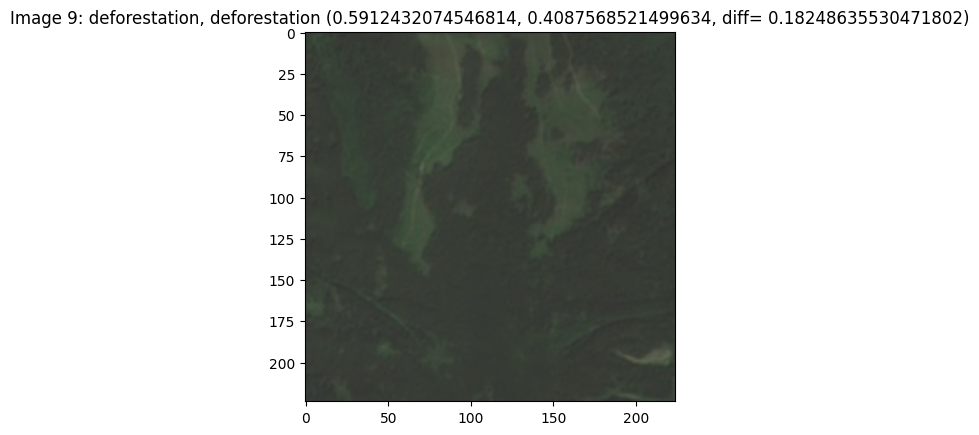

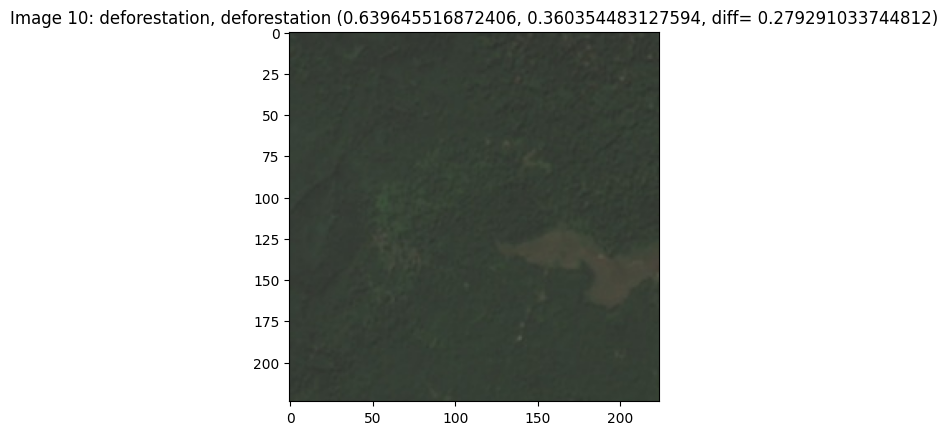

In [28]:
for i in range(10):
    image_path = incorrect_df['image'].iloc[i]
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f"Image {i+1}: {preds.iloc[i]['predicted label']}, {preds.iloc[i]['label']} ({incorrect_df.iloc[i]['probability of correct class']}, {incorrect_df.iloc[i]['probability of incorrect class']}, diff= {incorrect_df.iloc[i]['diff']})")
    plt.show()

In [29]:
cm = pd.crosstab(preds['label'], preds['predicted label'], rownames=['True'], colnames=['Predicted'], margins=False)

In [30]:
cm

Predicted          deforestation  not_deforestation
True                                               
deforestation               1008                115
not_deforestation            226                236

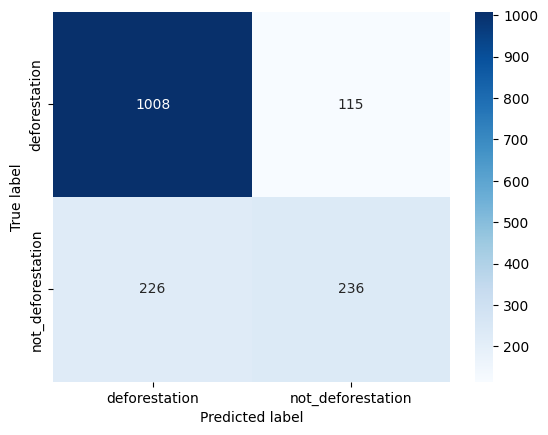

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [32]:
from sklearn.metrics import classification_report

true_labels_array = preds['label'].to_numpy()
pred_labels_array = preds['predicted label'].to_numpy()

print(classification_report(true_labels_array, pred_labels_array))

                   precision    recall  f1-score   support

    deforestation       0.82      0.90      0.86      1123
not_deforestation       0.67      0.51      0.58       462

         accuracy                           0.78      1585
        macro avg       0.74      0.70      0.72      1585
     weighted avg       0.77      0.78      0.78      1585



In [33]:
incorrect_predictions = (true_labels_array != pred_labels_array).sum()

misclassification_error = incorrect_predictions / len(true_labels_array)

print(f'Misclassification error: {misclassification_error:.4f}')


Misclassification error: 0.2151
